## Healthcon Variable and Frailty Index

#### Gavin Qu, May 30th - June 13th

#### Extract the hcond and disdif data, and handle missing values

In [4]:
import pandas as pd
import numpy as np
import os

base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# Define all variable sets
base_hcond_variables = ['hcond' + str(i) for i in range(1, 17)]
hcondn_variables = ['hcondn' + str(i) for i in range(1, 17)]
hcondever_variables = ['hcondever' + str(i) for i in range(1, 17)]
hcondnew_variables = ['hcondnew' + str(i) for i in range(1, 17) if i != 9]
disdif_variables = ['disdif' + str(i) for i in range(1, 12)]

prefixes = list('abcdefghijklm')

def load_wave_data(prefix, variables, wave_number):
    file_path = os.path.join(base_dir, f'{prefix}_indresp.dta')
    try:
        df = pd.read_stata(file_path, convert_categoricals=False)
        available_vars = [var for var in [f'{prefix}_{var}' for var in variables] if var in df.columns]
        required_vars = ['pidp'] + available_vars
        df = df[required_vars]
        
        # Remove prefix from column names
        df.columns = [col.replace(f'{prefix}_', '') for col in df.columns]
        
        # Add wave column
        df['wave'] = wave_number
        
        return df
    except Exception as e:
        print(f"Error loading data for wave {prefix}: {str(e)}")
        return None

variables_per_wave = {
    'a': base_hcond_variables + disdif_variables,
    'b': disdif_variables + hcondn_variables,
    'c': hcondn_variables + base_hcond_variables + disdif_variables,
    'd': hcondn_variables + base_hcond_variables + disdif_variables,
    'e': hcondn_variables + base_hcond_variables + disdif_variables,
    'f': hcondn_variables + base_hcond_variables + disdif_variables,
    'g': hcondn_variables + base_hcond_variables + disdif_variables,
    'h': hcondn_variables + base_hcond_variables + disdif_variables,
    'i': hcondn_variables + base_hcond_variables + disdif_variables,
    'j': hcondever_variables + base_hcond_variables + disdif_variables,
    'k': hcondnew_variables + base_hcond_variables + disdif_variables,
    'l': hcondnew_variables + base_hcond_variables + disdif_variables,
    'm': hcondnew_variables + base_hcond_variables + disdif_variables
}

data_frames = []

for wave_number, prefix in enumerate(prefixes, start=1):
    variables = variables_per_wave[prefix]
    df = load_wave_data(prefix, variables, wave_number)
    if df is not None:
        data_frames.append(df)
        print(f"Loaded data for wave {wave_number}: {df.shape[0]} rows, {df.shape[1]} columns")

df_all = pd.concat(data_frames, ignore_index=True)

# Replace negative values with NaN
df_all.replace({i: np.nan for i in range(-9, 0)}, inplace=True)

# Basic data validation
print(f"Combined dataset shape: {df_all.shape}")
print(f"Number of unique individuals: {df_all['pidp'].nunique()}")

# Save combined DataFrame to a new CSV file
df_all.to_csv("combined_UKHLS_data.csv", index=False)
print("Data saved to combined_UKHLS_data.csv")

Loaded data for wave 1: 50994 rows, 29 columns
Loaded data for wave 2: 54569 rows, 29 columns


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_42243/3582681760.py:19: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata(file_path, convert_categoricals=False)


Loaded data for wave 3: 49692 rows, 45 columns
Loaded data for wave 4: 47074 rows, 45 columns


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_42243/3582681760.py:19: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata(file_path, convert_categoricals=False)


Loaded data for wave 5: 44837 rows, 45 columns
Loaded data for wave 6: 45192 rows, 45 columns
Loaded data for wave 7: 42170 rows, 45 columns
Loaded data for wave 8: 39294 rows, 45 columns
Loaded data for wave 9: 36058 rows, 45 columns
Loaded data for wave 10: 34319 rows, 43 columns
Loaded data for wave 11: 32008 rows, 43 columns
Loaded data for wave 12: 29271 rows, 43 columns
Loaded data for wave 13: 27998 rows, 43 columns
Combined dataset shape: (533476, 75)
Number of unique individuals: 89348
Data saved to combined_UKHLS_data.csv


### Test for extracted dataset that print out the count of 1, 0 and NaN

In [5]:
import pandas as pd

# Load the extracted dataset
df = pd.read_csv("combined_UKHLS_data.csv")

# Get the list of variable names
variables = df.columns.tolist()

# Create a DataFrame to store the counts
counts_df = pd.DataFrame(columns=['variable', 'count_missing', 'count_1', 'count_0'])

# Iterate over each variable and count the values
for var in variables:
    count_missing = df[var].isna().sum()
    count_1 = df[var].eq(1).sum()
    count_0 = df[var].eq(0).sum()
    
    new_row = pd.DataFrame({
        'variable': [var],
        'count_missing': [count_missing],
        'count_1': [count_1],
        'count_0': [count_0]
    })
    
    counts_df = pd.concat([counts_df, new_row], ignore_index=True)

# Print the counts for each variable
print(counts_df)

      variable count_missing count_1 count_0
0         pidp             0       0       0
1       hcond1        465090    8862   59524
2       hcond2        465090    7576   60810
3       hcond3        465090     311   68075
4       hcond4        465090     952   67434
..         ...           ...     ...     ...
70  hcondnew12        447986     321   85169
71  hcondnew13        447986     940   84550
72  hcondnew14        447986    1832   83658
73  hcondnew15        447986     144   85346
74  hcondnew16        447986    3250   82240

[75 rows x 4 columns]


### Constructing {prefix}_healthcond1-16 Variables

This approach ensures that:

- Once an individual is diagnosed with a condition (value 1), this diagnosis is carried forward to all future waves for that individual.
- If an individual doesn't have a condition (value 0), this remains 0 unless changed in a future wave.
- Missing values (NaN) are preserved unless overwritten by a 0 or 1 in the same or a future wave.

In [6]:
import pandas as pd
import numpy as np

# Load the extracted dataset
df_all = pd.read_csv("combined_UKHLS_data.csv")

# List of health condition numbers
condition_numbers = range(1, 17)

# Function to get the relevant health condition column
def get_health_column(df, number):
    columns = [f"hcond{number}", f"hcondn{number}", 
               f"hcondnew{number}", f"hcondever{number}"]
    for col in columns:
        if col in df.columns:
            return col
    return None

# Initialize healthcond columns
for i in condition_numbers:
    df_all[f"healthcond{i}"] = np.nan

# Process each health condition
for i in condition_numbers:
    health_col = get_health_column(df_all, i)
    
    if health_col:
        # Sort the dataframe by pidp and wave to ensure correct order
        df_all = df_all.sort_values(['pidp', 'wave'])
        
        # Group by pidp and calculate cumulative maximum
        df_all[f"healthcond{i}"] = df_all.groupby('pidp')[health_col].cummax()

# Convert healthcond columns to appropriate type (0, 1, or NaN)
for i in condition_numbers:
    col = f"healthcond{i}"
    df_all[col] = df_all[col].map({0.0: 0, 1.0: 1})

# Remove original health condition columns to save space
original_health_cols = [col for col in df_all.columns if col.startswith(('hcond', 'hcondn', 'hcondnew', 'hcondever'))]
df_all = df_all.drop(columns=original_health_cols)

# Save the updated DataFrame to a new CSV file
df_all.to_csv("combined_UKHLS_data_updated.csv", index=False)

print("Data processing completed and saved to combined_UKHLS_data_updated.csv")
print(f"Final dataset shape: {df_all.shape}")
print(f"Number of unique individuals: {df_all['pidp'].nunique()}")

Data processing completed and saved to combined_UKHLS_data_updated.csv
Final dataset shape: (533476, 29)
Number of unique individuals: 89348


#### Count the values of healthcond when they are 1, 0 and missing. 

In [7]:
import pandas as pd

# Load the updated dataset
df_all = pd.read_csv("combined_UKHLS_data_updated.csv")

# Get the number of waves
num_waves = df_all['wave'].max()

# Create an empty DataFrame to store the counts
counts_df = pd.DataFrame(columns=['wave', 'variable', 'count_1', 'count_0', 'count_missing'])

# Iterate over each wave and count the values for each healthcond variable
for wave in range(1, num_waves + 1):
    wave_data = df_all[df_all['wave'] == wave]
    
    for i in range(1, 17):
        healthcond_col = f"healthcond{i}"
        
        if healthcond_col in df_all.columns:
            count_1 = wave_data[healthcond_col].eq(1).sum()
            count_0 = wave_data[healthcond_col].eq(0).sum()
            count_missing = wave_data[healthcond_col].isna().sum()
            
            new_row = pd.DataFrame({
                'wave': [wave],
                'variable': [healthcond_col],
                'count_1': [count_1],
                'count_0': [count_0],
                'count_missing': [count_missing]
            })
            
            counts_df = pd.concat([counts_df, new_row], ignore_index=True)

# Print the counts for each healthcond variable by wave
print(counts_df)

# Optionally, save the counts to a CSV file
counts_df.to_csv("healthcond_counts_by_wave.csv", index=False)
print("Counts saved to healthcond_counts_by_wave.csv")

# Print summary statistics
total_observations = len(df_all)
total_individuals = df_all['pidp'].nunique()
print(f"\nTotal number of observations: {total_observations}")
print(f"Total number of unique individuals: {total_individuals}")

# Calculate and print the percentage of 1s, 0s, and NaNs across all healthcond variables and waves
total_1s = counts_df['count_1'].sum()
total_0s = counts_df['count_0'].sum()
total_missing = counts_df['count_missing'].sum()
total_values = total_1s + total_0s + total_missing

print(f"\nPercentage of 1s across all healthcond variables and waves: {total_1s/total_values:.2%}")
print(f"Percentage of 0s across all healthcond variables and waves: {total_0s/total_values:.2%}")
print(f"Percentage of NaNs across all healthcond variables and waves: {total_missing/total_values:.2%}")

    wave      variable count_1 count_0 count_missing
0      1   healthcond1    6269   41336          3389
1      1   healthcond2    6769   40836          3389
2      1   healthcond3     276   47329          3389
3      1   healthcond4     854   46751          3389
4      1   healthcond5    1353   46252          3389
..   ...           ...     ...     ...           ...
203   13  healthcond12       2     790         27206
204   13  healthcond13       7     785         27206
205   13  healthcond14      17     775         27206
206   13  healthcond15       5     787         27206
207   13  healthcond16      20     772         27206

[208 rows x 5 columns]
Counts saved to healthcond_counts_by_wave.csv

Total number of observations: 533476
Total number of unique individuals: 89348

Percentage of 1s across all healthcond variables and waves: 0.49%
Percentage of 0s across all healthcond variables and waves: 12.29%
Percentage of NaNs across all healthcond variables and waves: 87.22%


#### First, we want to investigate how the death variable is recorded in the dataset.

In [23]:
import pandas as pd
import os

# Base directory containing the data
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# Load the death data from xwavedat.dta
xwave_df = pd.read_stata(os.path.join(base_dir, 'xwavedat.dta'))

# Check the columns in the dataset
print("Columns in xwavedat.dta:")
print(xwave_df.columns)

# Look at the 'dcsedw_dv' column if it exists
if 'dcsedw_dv' in xwave_df.columns:
    print("\nUnique values in dcsedw_dv:")
    print(xwave_df['dcsedw_dv'].value_counts(dropna=False))
    
    print("\nSample of dcsedw_dv (first 10 non-null values):")
    print(xwave_df[xwave_df['dcsedw_dv'].notna()]['dcsedw_dv'].head(10))
else:
    print("\n'dcsedw_dv' column not found. Searching for death-related columns...")
    death_cols = [col for col in xwave_df.columns if 'death' in col.lower() or 'die' in col.lower() or 'deceased' in col.lower()]
    if death_cols:
        print(f"Potential death-related columns found: {death_cols}")
        for col in death_cols:
            print(f"\nUnique values in {col}:")
            print(xwave_df[col].value_counts(dropna=False))
    else:
        print("No obvious death-related columns found.")

# Check for any columns that might indicate wave
wave_cols = [col for col in xwave_df.columns if 'wave' in col.lower()]
if wave_cols:
    print(f"\nPotential wave-related columns: {wave_cols}")
    for col in wave_cols:
        print(f"\nUnique values in {col}:")
        print(xwave_df[col].value_counts(dropna=False))

print("\nDataset shape:", xwave_df.shape)
print("Number of unique pidp:", xwave_df['pidp'].nunique())

Columns in xwavedat.dta:
Index(['pidp', 'pid', 'xwdat_dv', 'hhorig', 'memorig', 'memorig_bh', 'quarter',
       'psu', 'strata', 'sampst',
       ...
       'b_mortus_tw', 'c_mortus_tw', 'd_mortus_tw', 'e_mortus_tw',
       'f_mortus_tw', 'g_mortus_tw', 'h_mortus_tw', 'psnenus_xd', 'psnengp_xd',
       'psnenub_xd'],
      dtype='object', length=175)

Unique values in dcsedw_dv:
dcsedw_dv
inapplicable     144243
UKHLS Wave 22       457
UKHLS Wave 25       433
UKHLS Wave 26       432
UKHLS Wave 21       381
UKHLS Wave 27       378
UKHLS Wave 28       366
UKHLS Wave 24       351
UKHLS Wave 23       347
UKHLS Wave 29       346
UKHLS Wave 31       340
UKHLS Wave 30       337
BHPS Wave 14        293
UKHLS Wave 20       276
BHPS Wave 10        232
BHPS Wave 16        190
BHPS Wave 12        173
BHPS Wave 13        155
BHPS Wave 17        154
BHPS Wave 15        150
BHPS Wave 8         149
BHPS Wave 11        143
BHPS Wave 18        137
BHPS Wave 9         124
BHPS Wave 7         123
BHPS Wav

### Add age and death data

In [28]:
import pandas as pd
import os

# Base directory containing the data
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# Load the combined data
df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/combined_UKHLS_data_updated.csv")

# Ensure 'wave' is an integer
df_all['wave'] = pd.to_numeric(df_all['wave'], errors='coerce').astype('Int64')

# Load the death data from xwavedat.dta
xwave_df = pd.read_stata(os.path.join(base_dir, 'xwavedat.dta'))

# Mapping UKHLS Wave to our wave numbers
death_mapping = {
    'UKHLS Wave 20': 2, 'UKHLS Wave 21': 3, 'UKHLS Wave 22': 4, 'UKHLS Wave 23': 5,
    'UKHLS Wave 24': 6, 'UKHLS Wave 25': 7, 'UKHLS Wave 26': 8, 'UKHLS Wave 27': 9,
    'UKHLS Wave 28': 10, 'UKHLS Wave 29': 11, 'UKHLS Wave 30': 12, 'UKHLS Wave 31': 13
}

# Function to determine the death wave (only for UKHLS waves)
def get_death_wave(dcsedw_dv):
    if pd.isna(dcsedw_dv) or dcsedw_dv == 'inapplicable' or not str(dcsedw_dv).startswith('UKHLS'):
        return None
    return death_mapping.get(dcsedw_dv)

# Apply the function to get death wave
xwave_df['death_wave'] = xwave_df['dcsedw_dv'].apply(get_death_wave)

# Merge death data to df_all
df_all = df_all.merge(xwave_df[['pidp', 'death_wave']], on='pidp', how='left')

# Mark death in the relevant waves
df_all['death'] = (df_all['wave'] >= df_all['death_wave']) & (df_all['death_wave'].notna())

# Drop the death_wave column as it's no longer needed
df_all = df_all.drop(columns=['death_wave'])

# Save the updated DataFrame to a new CSV file
df_all.to_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_death.csv", index=False)

print("Data processing completed.")
print(f"Final dataset shape: {df_all.shape}")
print(f"Number of unique individuals: {df_all['pidp'].nunique()}")
print(f"Number of waves: {df_all['wave'].nunique()}")
print(f"Number of deaths: {df_all['death'].sum()}")

# Count deaths by wave
death_counts = df_all.groupby('wave')['death'].sum()
print("\nDeath counts by wave:")
print(death_counts)

# Check for any individuals with multiple death records
multiple_deaths = df_all.groupby('pidp')['death'].sum() > 1
if multiple_deaths.any():
    print(f"\nWarning: {multiple_deaths.sum()} individuals have multiple death records.")

# Print the first few rows where death is recorded
print("\nSample of rows with death recorded:")
print(df_all[df_all['death'] == True].head())

Data processing completed.
Final dataset shape: (533476, 30)
Number of unique individuals: 89348
Number of waves: 13
Number of deaths: 0

Death counts by wave:
wave
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
Name: death, dtype: Int64

Sample of rows with death recorded:
Empty DataFrame
Columns: [pidp, disdif1, disdif2, disdif3, disdif4, disdif5, disdif6, disdif7, disdif8, disdif9, disdif10, disdif11, wave, healthcond1, healthcond2, healthcond3, healthcond4, healthcond5, healthcond6, healthcond7, healthcond8, healthcond9, healthcond10, healthcond11, healthcond12, healthcond13, healthcond14, healthcond15, healthcond16, death]
Index: []

[0 rows x 30 columns]


####  Check Death Count and Valid Age Data

In [25]:
import pandas as pd

# Load the updated data
df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv")

# Function to calculate death count and check valid age data for each wave
def check_death_count_and_age_data(df):
    death_counts = {}
    age_validity = {}

    for wave in sorted(df['wave'].unique()):
        wave_data = df[df['wave'] == wave]
        
        # Count deaths
        death_counts[wave] = wave_data['death'].sum()
        
        # Check age validity
        valid_age_count = wave_data['age'].notna().sum()
        total_count = len(wave_data)
        age_validity[wave] = f'{valid_age_count} out of {total_count} have valid age data'

    return death_counts, age_validity

# Check death count and age data validity
death_counts, age_validity = check_death_count_and_age_data(df_all)

# Print the results
print("Death Counts for Each Wave:")
for wave, count in death_counts.items():
    print(f"Wave {wave}: {count}")

print("\nAge Data Validity for Each Wave:")
for wave, validity in age_validity.items():
    print(f"Wave {wave}: {validity}")

# Additional summary statistics
print("\nSummary Statistics:")
print(f"Total number of observations: {len(df_all)}")
print(f"Number of unique individuals: {df_all['pidp'].nunique()}")
print(f"Total number of deaths: {df_all['death'].sum()}")
print(f"Total number of valid age entries: {df_all['age'].notna().sum()}")
print(f"Age range: {df_all['age'].min()} to {df_all['age'].max()}")

# Check for any inconsistencies in death data
death_inconsistencies = df_all.groupby('pidp').apply(lambda x: (x['death'] == 1).sum() > 1).sum()
if death_inconsistencies > 0:
    print(f"\nWarning: {death_inconsistencies} individuals have more than one death record.")

# Check for age inconsistencies
df_all['age_diff'] = df_all.groupby('pidp')['age'].diff()
age_inconsistencies = ((df_all['age_diff'] < 0) | (df_all['age_diff'] > 2)).sum()
if age_inconsistencies > 0:
    print(f"\nWarning: {age_inconsistencies} instances where age does not increase consistently between waves.")

Death Counts for Each Wave:
Wave 1: 0
Wave 2: 0
Wave 3: 0
Wave 4: 0
Wave 5: 0
Wave 6: 0
Wave 7: 0
Wave 8: 0
Wave 9: 0
Wave 10: 0
Wave 11: 0
Wave 12: 0
Wave 13: 0

Age Data Validity for Each Wave:
Wave 1: 50994 out of 50994 have valid age data
Wave 2: 54567 out of 54569 have valid age data
Wave 3: 49691 out of 49692 have valid age data
Wave 4: 47074 out of 47074 have valid age data
Wave 5: 44837 out of 44837 have valid age data
Wave 6: 45165 out of 45192 have valid age data
Wave 7: 42167 out of 42170 have valid age data
Wave 8: 39294 out of 39294 have valid age data
Wave 9: 36057 out of 36058 have valid age data
Wave 10: 34317 out of 34319 have valid age data
Wave 11: 32004 out of 32008 have valid age data
Wave 12: 29268 out of 29271 have valid age data
Wave 13: 27997 out of 27998 have valid age data

Summary Statistics:
Total number of observations: 533476
Number of unique individuals: 89348
Total number of deaths: 0
Total number of valid age entries: 533432
Age range: 15.0 to 104.0



/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_3660/3895099773.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  death_inconsistencies = df_all.groupby('pidp').apply(lambda x: (x['death'] == 1).sum() > 1).sum()


We see here that the death count is correct and it reflects the official counts of the UKHLS. Note: The above count is cumulative of all previous and current waves. 

### Frailty index with death counted as 1 using the healthcond and disdiff variables

I'm using death data from a .dta file extracted earlier 

In [30]:
import pandas as pd
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the file paths
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv"
death_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta"
output_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"

# Define the health condition and difficulty with daily task variables
health_cond_vars = [f'healthcond{i}' for i in range(1, 17)]
disdif_vars = [f'disdif{i}' for i in range(1, 12)]
all_vars = health_cond_vars + disdif_vars

# Load death data
death_df = pd.read_stata(death_file)

# Create a mapping between wave numbers and letters
wave_map = {i+1: chr(97+i) for i in range(13)}  # 1 -> 'a', 2 -> 'b', etc.

def compute_frailty_index(df):
    # Convert to numeric, replacing negative values with NaN
    for var in all_vars:
        if var in df.columns:
            df[var] = pd.to_numeric(df[var], errors='coerce')
            df[var] = df[var].where(df[var] >= 0, np.nan)

    # Calculate frailty
    present_vars = [var for var in all_vars if var in df.columns]
    df['frailty'] = df[present_vars].sum(axis=1) / len(present_vars)
    
    # Set frailty to NaN where all values are NaN
    df['frailty'] = df['frailty'].where(df[present_vars].notna().any(axis=1), np.nan)
    
    return df

# Process the data in chunks to manage memory usage effectively
chunk_size = 10000  # Adjust chunk size based on memory availability
first_chunk = True

try:
    for chunk_number, df_chunk in enumerate(pd.read_csv(data_file, chunksize=chunk_size, low_memory=False)):
        logging.info(f"Processing chunk {chunk_number + 1}")
        
        # Merge with death data
        df_chunk = df_chunk.merge(death_df, on='pidp', how='left')
        
        # Compute frailty index
        df_chunk = compute_frailty_index(df_chunk)
        
        # Handle death
        for wave, letter in wave_map.items():
            death_col = f'{letter}_death'
            if death_col in df_chunk.columns:
                df_chunk.loc[(df_chunk['wave'] == wave) & (df_chunk[death_col] == 1), 'frailty'] = 1.0
        
        # Data validation
        invalid_frailty = df_chunk[(df_chunk['frailty'] < 0) | (df_chunk['frailty'] > 1)]['frailty']
        if not invalid_frailty.empty:
            logging.warning(f"Invalid frailty values found: {invalid_frailty.tolist()}")
        
        if first_chunk:
            df_chunk.to_csv(output_file, index=False, mode='w', header=True)
            first_chunk = False
        else:
            df_chunk.to_csv(output_file, index=False, mode='a', header=False)
        
        logging.info(f"Chunk {chunk_number + 1} processed and saved")

except Exception as e:
    logging.error(f"An error occurred: {str(e)}")

logging.info("Processing completed")

# Print summary statistics
try:
    df_summary = pd.read_csv(output_file, usecols=['pidp', 'wave', 'frailty'] + [f'{letter}_death' for letter in 'abcdefghijklm'])
    print(f"Total number of observations: {len(df_summary)}")
    print(f"Number of unique individuals: {df_summary['pidp'].nunique()}")
    print(f"Number of waves: {df_summary['wave'].nunique()}")
    print(f"Frailty range: {df_summary['frailty'].min()} to {df_summary['frailty'].max()}")
    
    # Calculate total deaths
    total_deaths = sum(df_summary[f'{letter}_death'].sum() for letter in 'abcdefghijklm')
    print(f"Number of deaths: {total_deaths}")
    
    print(f"Number of missing frailty values: {df_summary['frailty'].isna().sum()}")
    
    # Count frailty and deaths by wave
    frailty_stats = df_summary.groupby('wave').agg({
        'frailty': ['mean', 'median', 'std', 'count']
    })
    
    death_stats = {wave: df_summary[f'{wave_map[wave]}_death'].sum() for wave in range(1, 14)}
    frailty_stats['deaths'] = pd.Series(death_stats)
    
    print("\nFrailty statistics by wave:")
    print(frailty_stats)

except Exception as e:
    logging.error(f"An error occurred while generating summary statistics: {str(e)}")

2024-06-28 14:18:57,211 - INFO - Processing chunk 1
2024-06-28 14:19:09,816 - INFO - Chunk 1 processed and saved
2024-06-28 14:19:09,833 - INFO - Processing chunk 2
2024-06-28 14:19:18,403 - INFO - Chunk 2 processed and saved
2024-06-28 14:19:18,418 - INFO - Processing chunk 3
2024-06-28 14:19:25,685 - INFO - Chunk 3 processed and saved
2024-06-28 14:19:25,701 - INFO - Processing chunk 4
2024-06-28 14:19:37,231 - INFO - Chunk 4 processed and saved
2024-06-28 14:19:37,248 - INFO - Processing chunk 5
2024-06-28 14:19:42,306 - INFO - Chunk 5 processed and saved
2024-06-28 14:19:42,317 - INFO - Processing chunk 6
2024-06-28 14:19:53,820 - INFO - Chunk 6 processed and saved
2024-06-28 14:19:53,839 - INFO - Processing chunk 7
2024-06-28 14:20:04,924 - INFO - Chunk 7 processed and saved
2024-06-28 14:20:04,939 - INFO - Processing chunk 8
2024-06-28 14:20:10,145 - INFO - Chunk 8 processed and saved
2024-06-28 14:20:10,161 - INFO - Processing chunk 9
2024-06-28 14:20:21,555 - INFO - Chunk 9 pro

### Total count of frailty by wave

In [ ]:
import pandas as pd
import numpy as np

# Path to the file containing frailty data
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"

# Read the data
df = pd.read_csv(data_file)

# List of waves
prefixes = list('abcdefghijklm')

# Check for duplicates based on 'pidp'
if 'pidp' in df.columns:
    initial_count = len(df)
    df.drop_duplicates(subset=['pidp'], inplace=True)
    final_count = len(df)
    if initial_count != final_count:
        print(f"Removed {initial_count - final_count} duplicate entries based on pidp.")

# Initialize a dictionary to store the results
frailty_stats = {}

# Compute statistics for each wave
for prefix in prefixes:
    frailty_var = f'{prefix}_frailty'
    if frailty_var in df.columns:
        # Calculate counts for different frailty conditions
        frailty_series = df[frailty_var]
        zero_frailty = np.sum(frailty_series == 0)
        positive_frailty = np.sum((frailty_series > 0) & (frailty_series < 1))
        missing_frailty = np.sum(frailty_series.isna())
        one_frailty = np.sum(frailty_series == 1)

        # Store the counts in the dictionary
        frailty_stats[prefix] = {
            'Zero Frailty': zero_frailty,
            'Positive Frailty': positive_frailty,
            'Missing Frailty': missing_frailty,
            'Frailty == 1': one_frailty,
            'Total': len(frailty_series)
        }

# Output the results
print("Frailty Counts for Each Wave:")
for prefix, stats in frailty_stats.items():
    print(f"Wave {prefix.upper()}:")
    for condition, count in stats.items():
        print(f"  {condition}: {count}")
    print(f"  Percentage with Positive Frailty: {stats['Positive Frailty'] / stats['Total']:.2%}")
    print()

### Mean and Median of Frailty by Wave

In [105]:
import pandas as pd

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# List of wave prefixes to process
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]  # Generates 'a' to 'm'

# Initialize a dictionary to store results
frailty_stats = {}

# Loop over each wave to calculate mean, median, and mode frailty
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    
    if frailty_col in df.columns:
        df[frailty_col] = pd.to_numeric(df[frailty_col], errors='coerce')  # Convert to numeric, coercing errors
        
        # Filter out NaN values
        valid_frailty = df[frailty_col].dropna()
        
        # Calculate mean, median, and mode
        mean_frailty = valid_frailty.mean()
        median_frailty = valid_frailty.median()
        mode_frailty = valid_frailty.mode().tolist()  # Convert mode to a list
        
        # Store the results
        frailty_stats[prefix] = {'mean': mean_frailty, 'median': median_frailty, 'mode': mode_frailty}

# Print out the results
print("Mean, Median, and Mode Frailty by Wave:")
for prefix, stats in frailty_stats.items():
    print(f"Wave {prefix.upper()}: Mean = {stats['mean']}, Median = {stats['median']}, Mode = {stats['mode']}")

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/1124808273.py:5: DtypeWarning: Columns (730,731,734,735,737,738,739,740,741) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


Mean, Median, and Mode Frailty by Wave:
Wave A: Mean = 0.0493954192322559, Median = 0.0, Mode = [0.0]
Wave B: Mean = 0.0693977126671087, Median = 0.037037037037037, Mode = [0.037037037037037]
Wave C: Mean = 0.07698961723918901, Median = 0.037037037037037, Mode = [0.037037037037037]
Wave D: Mean = 0.09276081876130976, Median = 0.037037037037037, Mode = [0.037037037037037]
Wave E: Mean = 0.10924725500307561, Median = 0.037037037037037, Mode = [0.037037037037037]
Wave F: Mean = 0.1268314731209765, Median = 0.037037037037037, Mode = [0.037037037037037]
Wave G: Mean = 0.15127905301778558, Median = 0.037037037037037, Mode = [0.037037037037037]
Wave H: Mean = 0.13273316741687405, Median = 0.037037037037037, Mode = [0.037037037037037]
Wave I: Mean = 0.15502332295951304, Median = 0.037037037037037, Mode = [0.037037037037037]
Wave J: Mean = 0.31776694144510237, Median = 0.037037037037037, Mode = [0.0]
Wave K: Mean = 0.29118218095586074, Median = 0.037037037037037, Mode = [0.0]
Wave L: Mean = 0.3

### Distribution of Age

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/4282210731.py:7: DtypeWarning: Columns (427,428,431,432,434,435,436,437,438) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


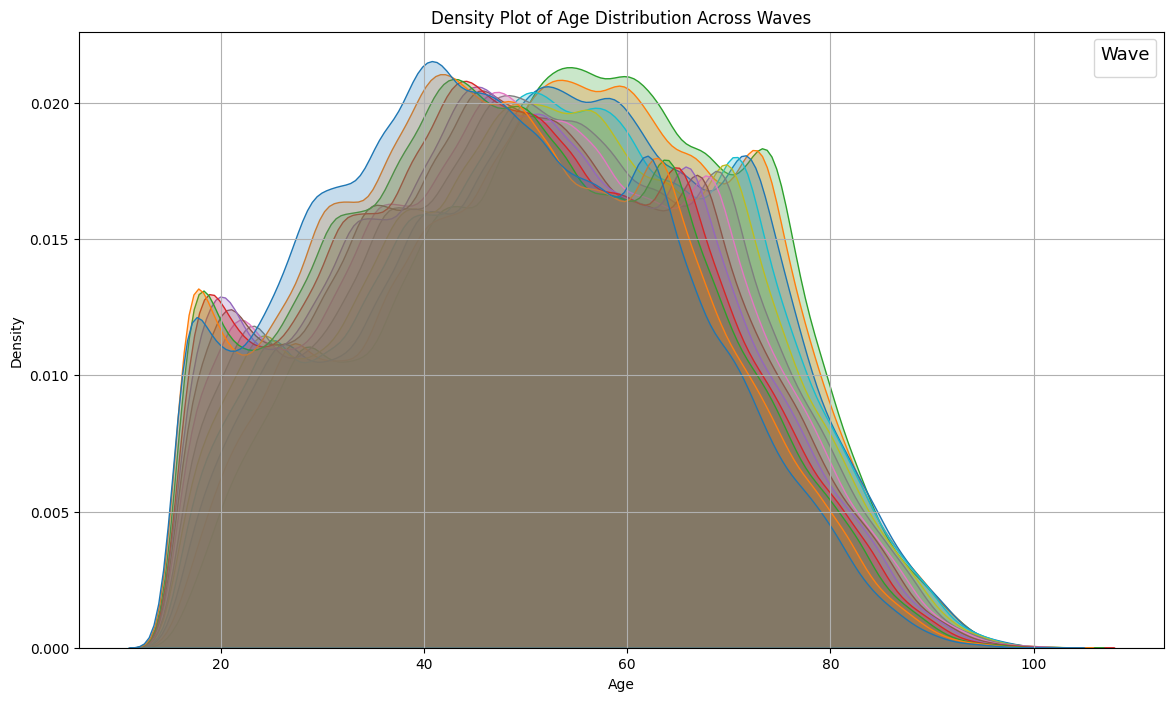

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# List of wave prefixes to process
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]  # Generates 'a' to 'm'

# Prepare data for plotting
age_data = pd.DataFrame()

# Loop over each wave to extract age data
for prefix in wave_prefixes:
    age_col = f'{prefix}_age_dv'

    # Check if the age column is in the dataframe
    if age_col in df.columns:
        df[age_col] = pd.to_numeric(df[age_col], errors='coerce')  # Convert to numeric, coercing errors
        # Collect age data into a single dataframe for plotting
        temp_df = df[['pidp', age_col]].dropna()  # Drop NaN values which can be from conversion or missing data
        temp_df = temp_df.rename(columns={age_col: 'age'})
        temp_df['wave'] = prefix  # Label each row with its wave for group by in plot
        age_data = pd.concat([age_data, temp_df], ignore_index=True)

# Create a density plot using seaborn
plt.figure(figsize=(14, 8))
sns.kdeplot(data=age_data, x='age', hue='wave', common_norm=False, palette='tab10', fill=True)
plt.title('Density Plot of Age Distribution Across Waves')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)
plt.legend(title='Wave', title_fontsize='13', fontsize='11')
plt.show()


### Density Plot of Frailty

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/2691889958.py:7: DtypeWarning: Columns (730,731,734,735,737,738,739,740,741) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


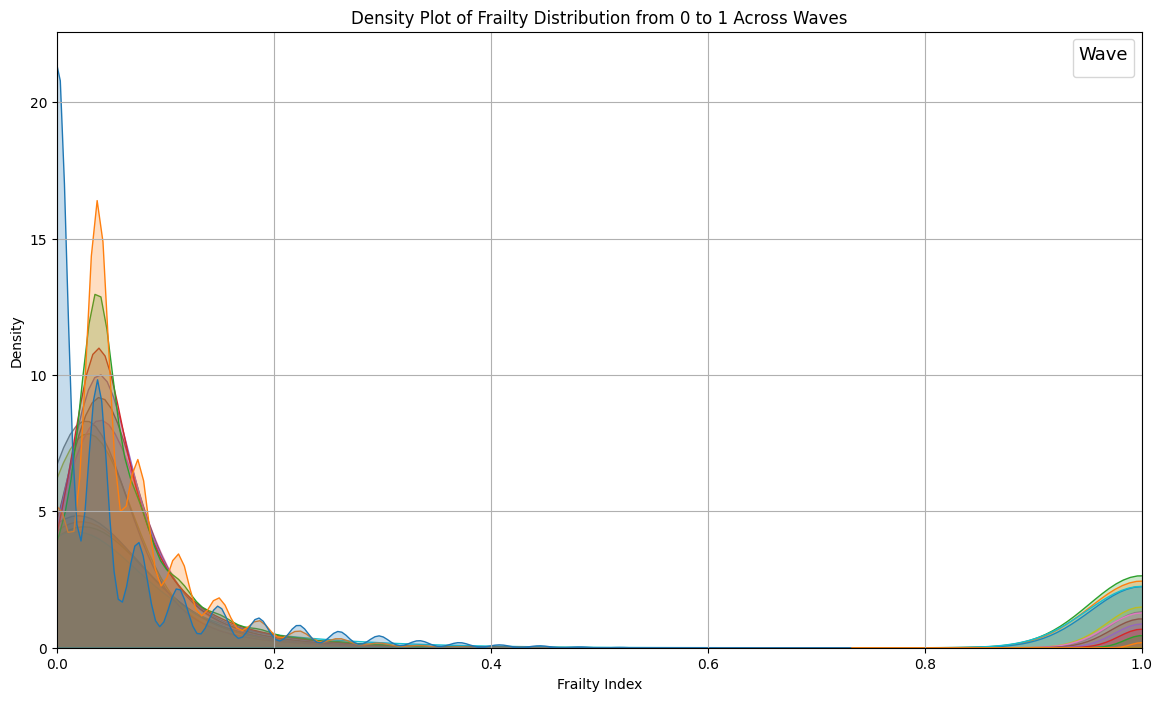

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# List of wave prefixes to process
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]  # Generates 'a' to 'm'

# Prepare data for plotting
frailty_data = pd.DataFrame()

# Loop over each wave to extract frailty data
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'

    # Check if the frailty column is in the dataframe
    if frailty_col in df.columns:
        df[frailty_col] = pd.to_numeric(df[frailty_col], errors='coerce')  # Convert to numeric, coercing errors
        # Filter to include only values between 0 and 1
        temp_df = df[['pidp', frailty_col]].dropna()  # Drop NaN values
        temp_df = temp_df[(temp_df[frailty_col] >= 0) & (temp_df[frailty_col] <= 1)]  # Ensure range is 0 to 1
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index'})
        temp_df['wave'] = prefix  # Label each row with its wave for group by in plot
        frailty_data = pd.concat([frailty_data, temp_df], ignore_index=True)

# Create a density plot using seaborn for the frailty index
plt.figure(figsize=(14, 8))
sns.kdeplot(data=frailty_data, x='frailty_index', hue='wave', common_norm=False, palette='tab10', fill=True)
plt.title('Density Plot of Frailty Distribution from 0 to 1 Across Waves')
plt.xlabel('Frailty Index')
plt.ylabel('Density')
plt.grid(True)
plt.legend(title='Wave', title_fontsize='13', fontsize='11')
plt.xlim(0, 1)  # Ensure the x-axis is limited to 0 to 1
plt.show()


### Smoothed Line Plot of Frailty against Age excluding missing value

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# Ensure 'age' and 'frailty' are numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['frailty'] = pd.to_numeric(df['frailty'], errors='coerce')

# Filter out invalid frailty indices and including only age >= 20
df = df[(df['frailty'].notna()) & 
        (df['frailty'] >= 0) & 
        (df['frailty'] <= 1) & 
        (df['age'] >= 20)]

# Group by age and calculate mean frailty index
grouped_data = df.groupby('age')['frailty'].agg(['mean', 'std']).reset_index()
grouped_data.columns = ['age', 'frailty_index', 'frailty_std']

# Create a plot
plt.figure(figsize=(12, 8))

# Plot average frailty index
sns.lineplot(x='age', y='frailty_index', data=grouped_data, label='Average Frailty Index')

# Add shaded area for standard deviation
plt.fill_between(grouped_data['age'], 
                 grouped_data['frailty_index'] - grouped_data['frailty_std'],
                 grouped_data['frailty_index'] + grouped_data['frailty_std'],
                 alpha=0.3)

# Customize the plot
plt.xlabel('Age')
plt.ylabel('Frailty Index')
plt.title('Average Frailty Index vs Age (with Standard Deviation)')
plt.grid(True)

# Add text box with summary statistics
total_observations = len(df)
unique_individuals = df['pidp'].nunique()
stats_text = f'Total Observations: {total_observations:,}\nUnique Individuals: {unique_individuals:,}'
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

# Print additional statistics
print(f"Age range: {df['age'].min()} to {df['age'].max()}")
print(f"Frailty index range: {df['frailty'].min():.4f} to {df['frailty'].max():.4f}")
print(f"Mean frailty index: {df['frailty'].mean():.4f}")
print(f"Median frailty index: {df['frailty'].median():.4f}")

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_37383/3510539476.py:8: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


: 

### Plot of non-zero and non-missing Disdif and Healthcond

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/3261819921.py:7: DtypeWarning: Columns (730,731,734,735,737,738,739,740,741) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


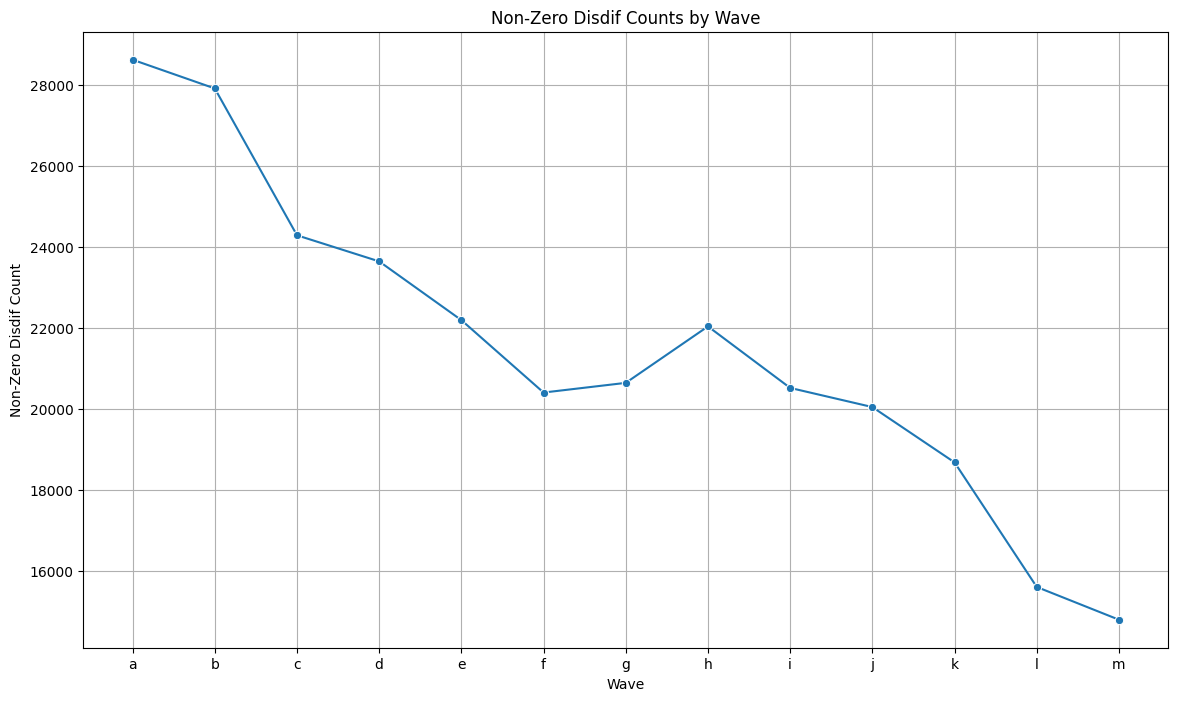

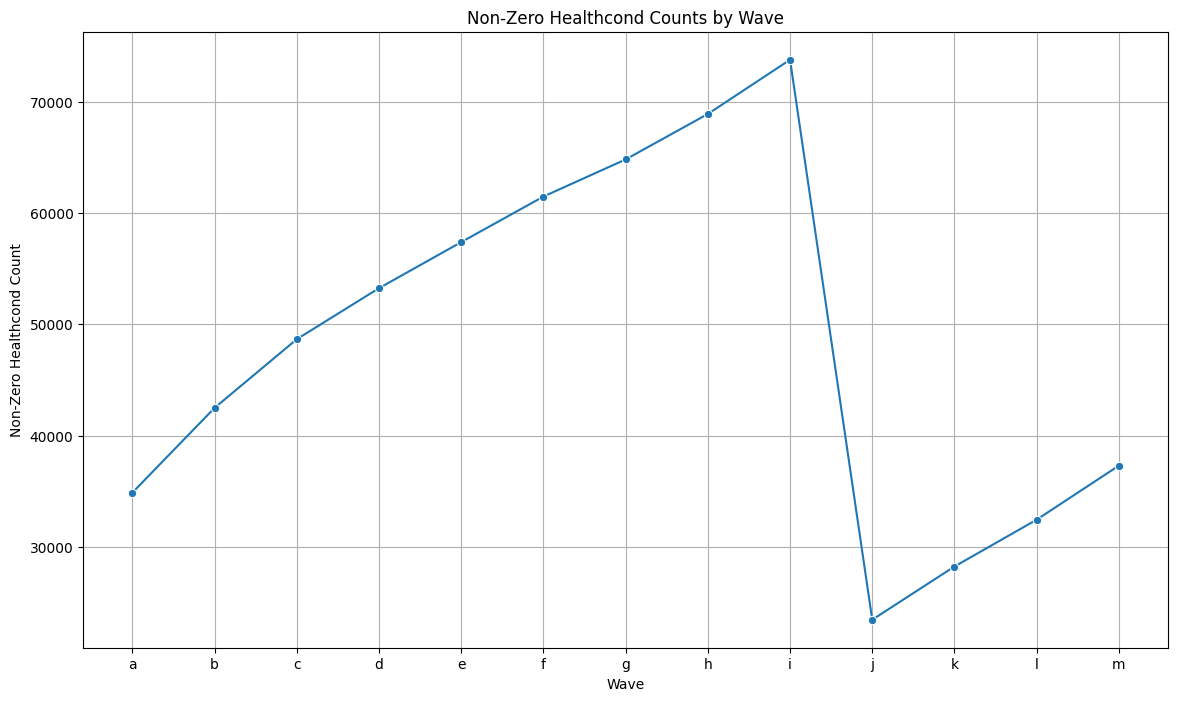

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# Define the waves and variable prefixes
waves = list('abcdefghijklm')  # Assuming waves 'a' through 'm'
disdif_vars = [f'disdif{i}' for i in range(1, 12)]
healthcond_vars = [f'healthcond{i}' for i in range(1, 17)]

# Prepare dataframes for storing counts
non_zero_disdif_counts = []
non_zero_healthcond_counts = []

# Calculate non-zero/non-missing counts for each wave
for wave in waves:
    wave_disdif_counts = df[[f'{wave}_{var}' for var in disdif_vars]].apply(lambda x: x[(x > 0) & (~x.isna())].count())
    wave_healthcond_counts = df[[f'{wave}_{var}' for var in healthcond_vars]].apply(lambda x: x[(x > 0) & (~x.isna())].count())

    non_zero_disdif_counts.append(wave_disdif_counts.sum())
    non_zero_healthcond_counts.append(wave_healthcond_counts.sum())

# Create DataFrames from the counts
non_zero_disdif_counts_df = pd.DataFrame(non_zero_disdif_counts, index=waves, columns=['Non-Zero Disdif'])
non_zero_healthcond_counts_df = pd.DataFrame(non_zero_healthcond_counts, index=waves, columns=['Non-Zero Healthcond'])

# Plotting Non-Zero Disdif Counts by Wave
plt.figure(figsize=(14, 8))
sns.lineplot(data=non_zero_disdif_counts_df, x=non_zero_disdif_counts_df.index, y='Non-Zero Disdif', marker='o')
plt.xlabel('Wave')
plt.ylabel('Non-Zero Disdif Count')
plt.title('Non-Zero Disdif Counts by Wave')
plt.grid(True)
plt.show()

# Plotting Non-Zero Healthcond Counts by Wave
plt.figure(figsize=(14, 8))
sns.lineplot(data=non_zero_healthcond_counts_df, x=non_zero_healthcond_counts_df.index, y='Non-Zero Healthcond', marker='o')
plt.xlabel('Wave')
plt.ylabel('Non-Zero Healthcond Count')
plt.title('Non-Zero Healthcond Counts by Wave')
plt.grid(True)
plt.show()


### Plot of Frailty == 1

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_3660/1180995770.py:7: DtypeWarning: Columns (730,731,734,735,737,738,739,740,741) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


Total number of individuals with frailty index of 1: 0


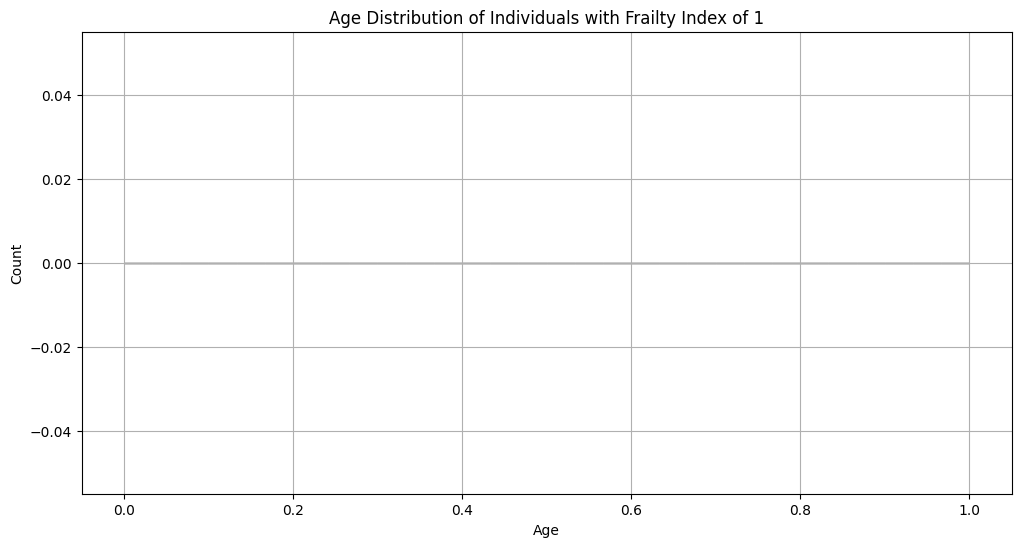

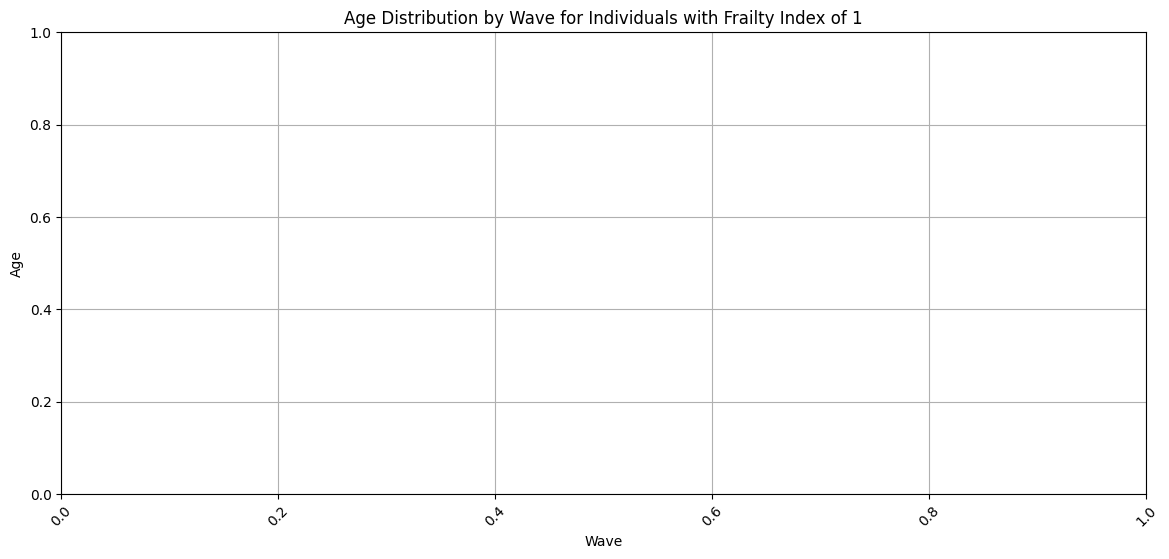

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# List of wave prefixes to process
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]  # Generates 'a' to 'm'

# Prepare data for individuals with frailty index of 1
frailty_one_data = pd.DataFrame()

# Loop over each wave to extract data for individuals with frailty index of 1
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    age_col = f'{prefix}_age_dv'
    
    if frailty_col in df.columns and age_col in df.columns:
        # Convert to numeric, coercing errors
        df[frailty_col] = pd.to_numeric(df[frailty_col], errors='coerce')
        df[age_col] = pd.to_numeric(df[age_col], errors='coerce')
        
        # Extract data for individuals with frailty index of 1
        temp_df = df[['pidp', frailty_col, age_col]].copy()
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index', age_col: 'age'})
        temp_df = temp_df[(temp_df['frailty_index'] == 1) & (temp_df['age'].notna())]
        
        # Add wave information
        temp_df['wave'] = prefix
        
        # Add data to the frailty_one_data DataFrame
        frailty_one_data = pd.concat([frailty_one_data, temp_df], ignore_index=True)

# Print the total number of individuals with frailty index of 1
print(f"Total number of individuals with frailty index of 1: {len(frailty_one_data)}")

# Create a histogram of ages for individuals with frailty index of 1
plt.figure(figsize=(12, 6))
sns.histplot(data=frailty_one_data, x='age', bins=30, kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution of Individuals with Frailty Index of 1')
plt.grid(True)
plt.show()

# Create a box plot of ages by wave for individuals with frailty index of 1
plt.figure(figsize=(14, 6))
sns.boxplot(data=frailty_one_data, x='wave', y='age')
plt.xlabel('Wave')
plt.ylabel('Age')
plt.title('Age Distribution by Wave for Individuals with Frailty Index of 1')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()